<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/3-classification/classification_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification Fundamentals

##Setup

In [57]:
# Common imports
import numpy as np
import os

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [21]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
  plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
      rimages = images[row * images_per_row : (row + 1) * images_per_row]
      row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap = mpl.cm.binary, **options)
  plt.axis("off")

##MNIST Dataset

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them.

In [13]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [14]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it.

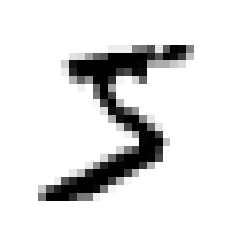

In [17]:
some_digit = X[:1]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [18]:
y[0]

'5'

Note that the label is a string.so let’s cast y to
integer:

In [20]:
y = y.astype(np.uint8)

Now, let's shows a few
more images from the MNIST dataset.

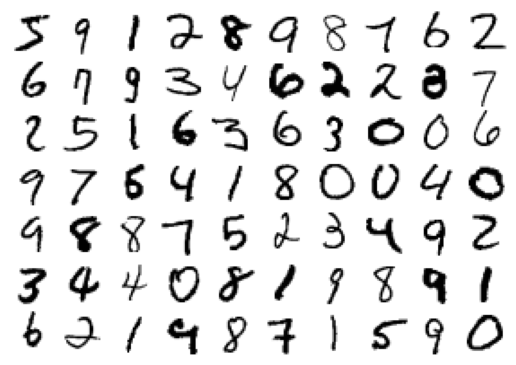

In [22]:
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [24]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

Some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. 

Shuffling the dataset ensures that this won’t happen.

In [25]:
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

##Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. 

Let’s create the target vectors for
this classification task:

In [26]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now, let's calculate total 5's and not 5's data point.

In [43]:
both_5_and_not_5 =len(y_train_5)
both_5_and_not_5

60000

In [44]:
total_not_5 = np.bitwise_not(y_train_5).sum()
total_not_5

54579

In [45]:
total_5 = both_5_and_not_5 - total_not_5
total_5

5421

In [50]:
(total_not_5 / both_5_and_not_5) * 100

90.96499999999999

In [51]:
(total_5 / both_5_and_not_5) * 100

9.035

So we have 90.96% not 5's data point and 9.03% 5's data point.In other words, we have now imbalanced dataset.

Now let’s pick a classifier and train it on this imbalanced dataset.

In [53]:
# set max_iter=5 and tol=-np.infty, to get the same results
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty ,random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

Now we can use it to detect images of the number 5:

In [56]:
sgd_clf.predict(some_digit)

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case!

##Performance Measures

###Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model,
using K-fold `cross-validation` with three folds. 

Remember that K-fold cross-validation
means splitting the training set into K folds (in this case, three), then making predictions
and evaluating them on each fold using a model trained on the remaining folds

In [58]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds?

Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [59]:
class Never5Classifier(BaseEstimator):
  def fit(self, x, y):
    pass
  def predict(self, x):
    return np.zeros((len(x), 1), dtype=bool)  

Can you guess this model’s accuracy? Let’s find out:

In [60]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

That’s right, it has over `90%` accuracy! This is simply because only about `10%` of the images are 5s, so if you always guess that an image is not a 5, you will be right about `90%` of the time.

**This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets or class imbalanced dataset** (i.e., when some classes are much more frequent than others).



###Confusion Matrix